In [1]:
import pandas as pd
from pyxlsb import open_workbook, convert_date
import matplotlib.pyplot as plt 
import seaborn as sns 

import re 
from rapidfuzz import process
from rapidfuzz import fuzz

file_path = '../../data/ecommerce_sales.xlsb'
sheet_name = '20210614 Ecommerce sales'

In [2]:
def read_xlsb(file_path, sheet_name):
    data = []
    with open_workbook(file_path) as wb:
        with wb.get_sheet(sheet_name) as sheet:
            for idx,row in enumerate(sheet.rows()):
                if idx == 0:
                    data.append([item.v for item in row])
                else:
                    data.append([item.v if item.c != 5 else convert_date(item.v) for item in row ])
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

In [3]:
data = read_xlsb(file_path, sheet_name)

In [4]:
mattress_data = data[data['Libellé produit'].str.contains('mattress', case=False, na=False) |
                     data['Nature'].str.contains('matelas', case=False, na=False) ]

In [5]:
mattress_data['Month'] = mattress_data['Date de commande'].dt.month
mattress_data['Year'] = mattress_data['Date de commande'].dt.year

C:\Users\jatin\AppData\Local\Temp\ipykernel_23636\227607427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mattress_data['Month'] = mattress_data['Date de commande'].dt.month
C:\Users\jatin\AppData\Local\Temp\ipykernel_23636\227607427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mattress_data['Year'] = mattress_data['Date de commande'].dt.year


In [6]:
# Predefined colors in French
FRENCH_COLORS = set([
    "rouge", "bleu", "vert", "jaune", "noir", "blanc", "orange", "rose", "violet", "marron", "gris", 
    "beige", "turquoise", "or", "argent", "ivoire", "bleu marine", "sarcelle", "bordeaux", "lavande", 
    "pêche", "citron vert", "corail", "cyan", "magenta", "olive", "saumon", "moutarde", "chocolat", 
    "charbon", "indigo", "rubis", "émeraude", "saphir", "doré", "argenté", "brun"
])

class ProductInfoExtractor:
    def __init__(self):
        self.dimension_pattern = re.compile(r'(\d+(?:[.,]\d+)?)\s*(?:x|×)\s*(\d+(?:[.,]\d+)?)\s*(?:cm|m)?')
        self.single_dim_pattern = re.compile(r'(\d+(?:[.,]\d+)?)\s*(?:cm|m)')
        self.word_split_pattern = re.compile(r'\b\w+\b')
        self.color_patterns = {color: re.compile(rf'\b{color}(?:s|es|e)?\b') for color in FRENCH_COLORS}

    def extract_info(self, description):
        if not description:
            return "N/F", "N/F"
        
        desc_lower = str(description).lower()
        dimensions = self.extract_dimensions(desc_lower)
        colors = self.extract_colors(desc_lower)
        return dimensions, colors

    def extract_dimensions(self, desc_lower):
        dimensions_match = self.dimension_pattern.findall(desc_lower)
        if dimensions_match:
            dim1, dim2 = dimensions_match[0]
            dim1 = float(dim1.replace(',', '.'))
            dim2 = float(dim2.replace(',', '.'))
            return f"{dim1:.0f}x{dim2:.0f}"
        else:
            single_dim_match = self.single_dim_pattern.findall(desc_lower)
            if single_dim_match:
                dim1 = float(single_dim_match[0].replace(',', '.'))
                return f"{dim1:.0f}"
            else:
                return "N/F"
    
    def find_matching_colors(self, desc_lower):
        words = desc_lower.split()
        matching_words = []
        for word in words:
            if any(color in word.lower() for color in FRENCH_COLORS):
                matching_words.append(word)
        
        return matching_words
    
    def extract_colors(self, desc_lower):
        colors = []
        matching_words = self.find_matching_colors(desc_lower)
        for word in matching_words:
            sim = process.extractOne(word, FRENCH_COLORS, scorer=fuzz.ratio, score_cutoff=75)
            if sim:
                colors.append(sim[0])
        return ", ".join(colors) if colors else "N/F"
            
# Usage with a DataFrame
extractor = ProductInfoExtractor()
mattress_data[['Dimensions', 'Color']] = mattress_data['Libellé produit'].apply(lambda x: pd.Series(extractor.extract_info(x)))

C:\Users\jatin\AppData\Local\Temp\ipykernel_23636\2897935227.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mattress_data[['Dimensions', 'Color']] = mattress_data['Libellé produit'].apply(lambda x: pd.Series(extractor.extract_info(x)))
C:\Users\jatin\AppData\Local\Temp\ipykernel_23636\2897935227.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mattress_data[['Dimensions', 'Color']] = mattress_data['Libellé produit'].apply(lambda x: pd.Series(extractor.extract_info(x)))


In [7]:
mattress_data

,Cod_cmd,Libellé produit,Vendeur,Univers,Nature,Date de commande,Montant cmd,Quantité,Prix transport,Délai transport annoncé,Month,Year,Dimensions,Color
72,183685444.0,Surmatelas mousse mémoire de forme 10 zones 90...,Autre vendeur,Chambre Literie,Surmatelas,2021-02-05,31.0,1.0,14.08,10.0,2,2021,90x190,N/F
344,181982876.0,Matelas Cosy 90x190cm 20 cm d épaisseur Mémoir...,Autre vendeur,Chambre Literie,Matelas,2021-01-16,157.0,1.0,0.00,12.0,1,2021,90x190,N/F
352,181986659.0,Matelas Atlanta 90x200 cm Ep 20cm Mémoire de f...,Autre vendeur,Chambre Literie,Matelas,2021-01-16,176.0,1.0,0.00,12.0,1,2021,90x200,N/F
377,182306769.0,Surmatelas cloud 140x190 cm mémoire de forme h...,Autre vendeur,Chambre Literie,Surmatelas,2021-01-20,203.0,1.0,0.00,7.0,1,2021,140x190,N/F
385,182277093.0,Matelas tri technologie 140x190 cm latex+mémoi...,Autre vendeur,Chambre Literie,Matelas,2021-01-20,494.0,1.0,0.00,7.0,1,2021,140x190,N/F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525012,211131124.0,Bamboo matelas 140x190 très ferme tissu bambou...,Autre vendeur,Chambre Literie,Matelas,2021-03-31,324.0,1.0,0.00,4.0,3,2021,140x190,N/F
525013,187019505.0,Matelas ferme pour tous bz 140x190 x 15 cm + l...,Autre vendeur,Chambre Literie,Matelas,2021-03-29,629.0,1.0,0.00,4.0,3,2021,140x190,N/F
525015,211055605.0,Matelas bambou 140x190 x 23 cm très ferme noya...,Autre vendeur,Chambre Literie,Matelas,2021-03-30,324.0,1.0,0.00,4.0,3,2021,140x190,N/F
525016,186990238.0,Lot de 2 matelas 23 cm 100x200 ferme mémoire d...,Autre vendeur,Chambre Literie,Matelas,2021-03-29,865.0,1.0,0.00,4.0,3,2021,100x200,N/F


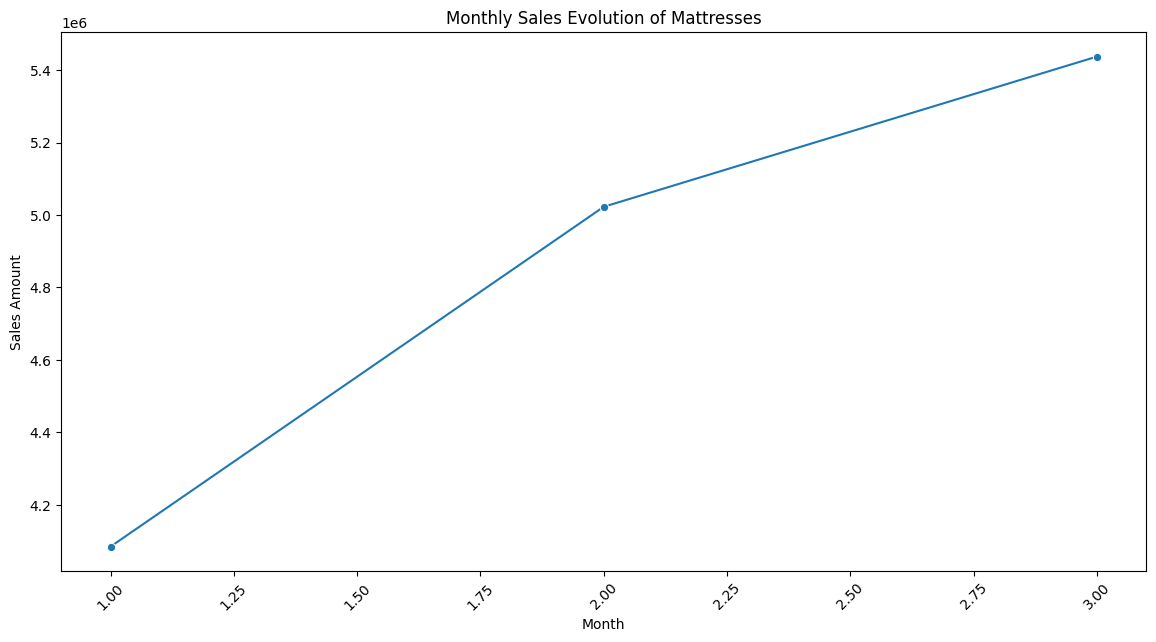

In [8]:
monthly_sales = mattress_data.groupby('Month')['Montant cmd'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales, x='Month', y='Montant cmd', marker='o')
plt.title('Monthly Sales Evolution of Mattresses')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.show()


Sales Trends shows steadly increases per month.

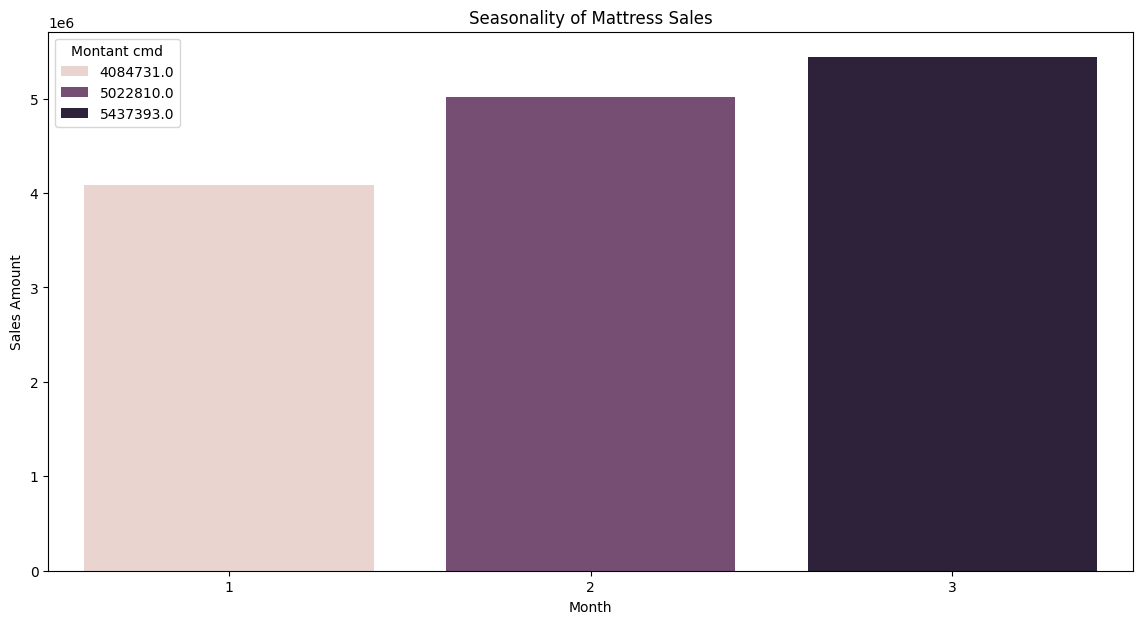

In [9]:
# Extract month and year from the Date for seasonality analysis


# Aggregate sales by month across all years
monthly_sales_seasonality = mattress_data.groupby('Month')['Montant cmd'].sum().reset_index()

# Plot seasonality of sales
plt.figure(figsize=(14, 7))
sns.barplot(data=monthly_sales_seasonality, x='Month', y='Montant cmd', hue='Montant cmd')
plt.title('Seasonality of Mattress Sales')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.show()


Sales steadily increased over the three months, from approximately 4.1 million in month 1 to around 5.4 million in month 3.

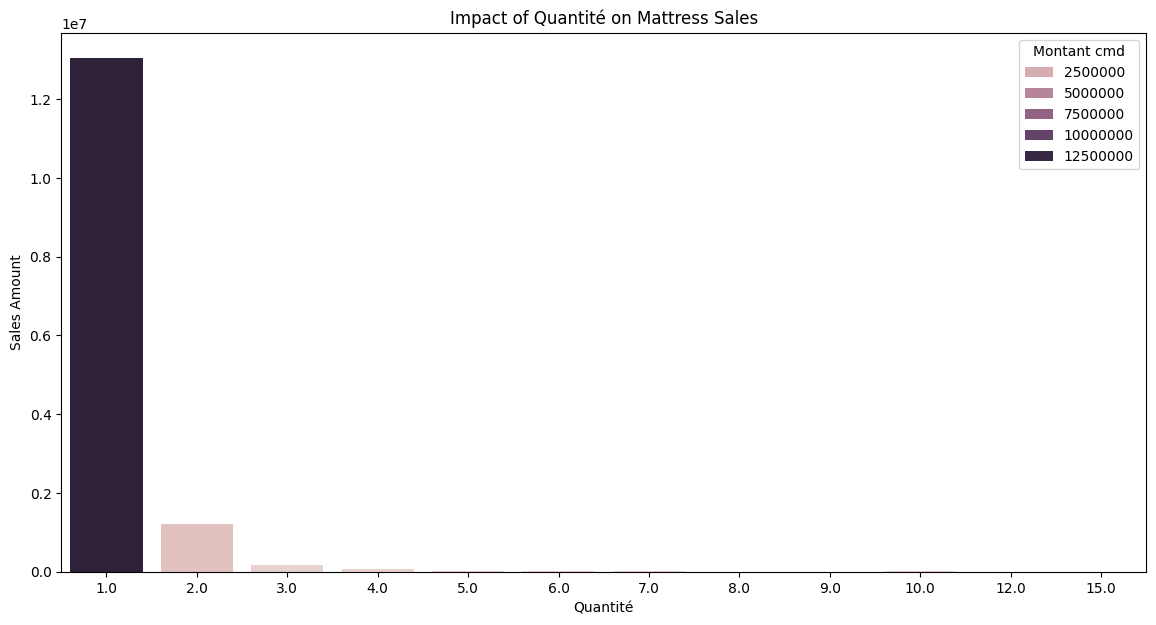

In [10]:
# Assuming there is a 'Discount' column indicating the discount percentage
# Aggregate sales by discount level
discount_sales = mattress_data.groupby('Quantité')['Montant cmd'].sum().reset_index()

# Plot sales by discount level
plt.figure(figsize=(14, 7))
sns.barplot(data=discount_sales, x='Quantité', y='Montant cmd', hue='Montant cmd')
plt.title('Impact of Quantité on Mattress Sales')
plt.xlabel('Quantité')
plt.ylabel('Sales Amount')
plt.show()


Majority of mattress sales occur when the quantity is 1. The sales amount drops drastically as the quantity increases

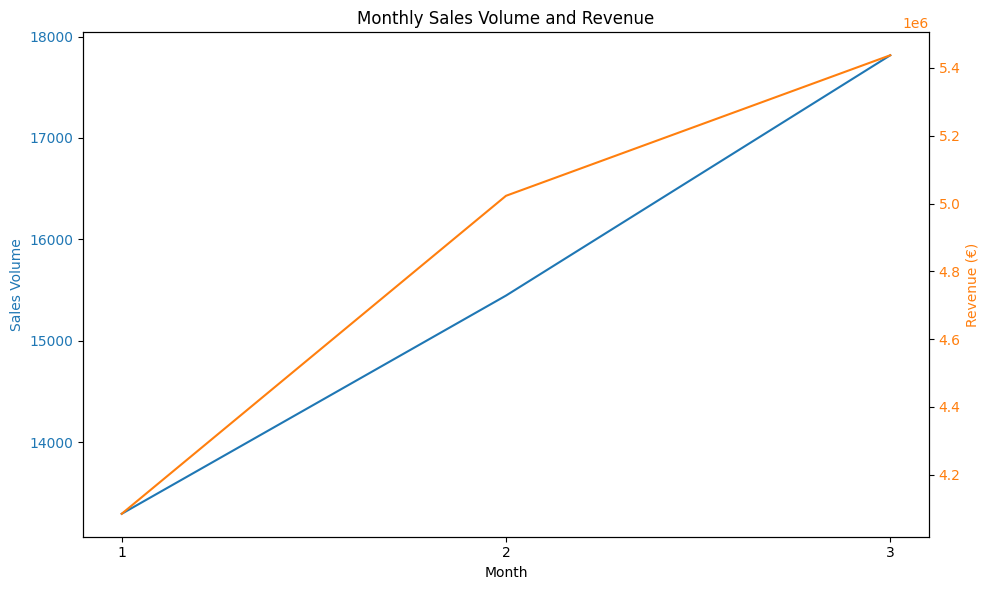

In [11]:
monthly_data = mattress_data.groupby('Month').agg({'Quantité': 'sum', 'Montant cmd': 'sum'}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Month')
ax1.set_ylabel('Sales Volume', color='tab:blue')
ax1.plot(monthly_data['Month'].astype(str), monthly_data['Quantité'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Revenue (€)', color='tab:orange')
ax2.plot(monthly_data['Month'].astype(str), monthly_data['Montant cmd'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Monthly Sales Volume and Revenue')
plt.tight_layout()
plt.show()

1. The blue line shows the sales volume, which is increasing from 13,250 in month 1 to 17,500 in month 3.
2. The orange line shows the revenue, which is increasing from 4.15 million in month 1 to 5.4 million in month 3.

C:\Users\jatin\AppData\Local\Temp\ipykernel_23636\853942506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mattress_data['Price Range'] = mattress_data['Montant cmd'].apply(price_range)


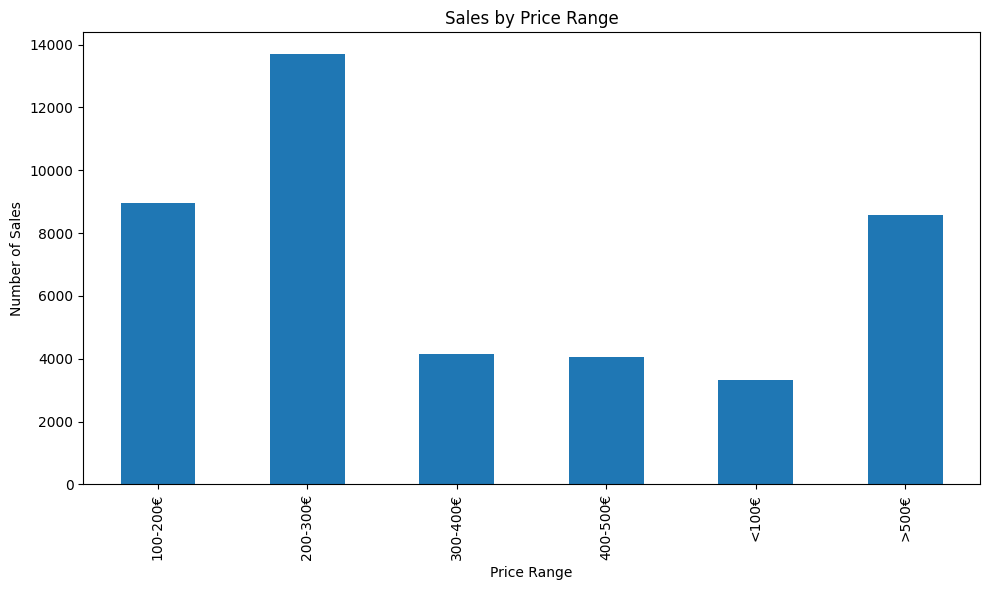

In [12]:
def price_range(price):
    if price < 100:
        return '<100€'
    elif price < 200:
        return '100-200€'
    elif price < 300:
        return '200-300€'
    elif price < 400:
        return '300-400€'
    elif price < 500:
        return '400-500€'
    else:
        return '>500€'

mattress_data['Price Range'] = mattress_data['Montant cmd'].apply(price_range)
price_range_counts = mattress_data['Price Range'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
price_range_counts.plot(kind='bar')
plt.title('Sales by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Sales')
plt.tight_layout()
plt.show()

Most customers are willing to pay a moderate price for the products, while a smaller number of customers are willing to pay a very high price or a very low price.

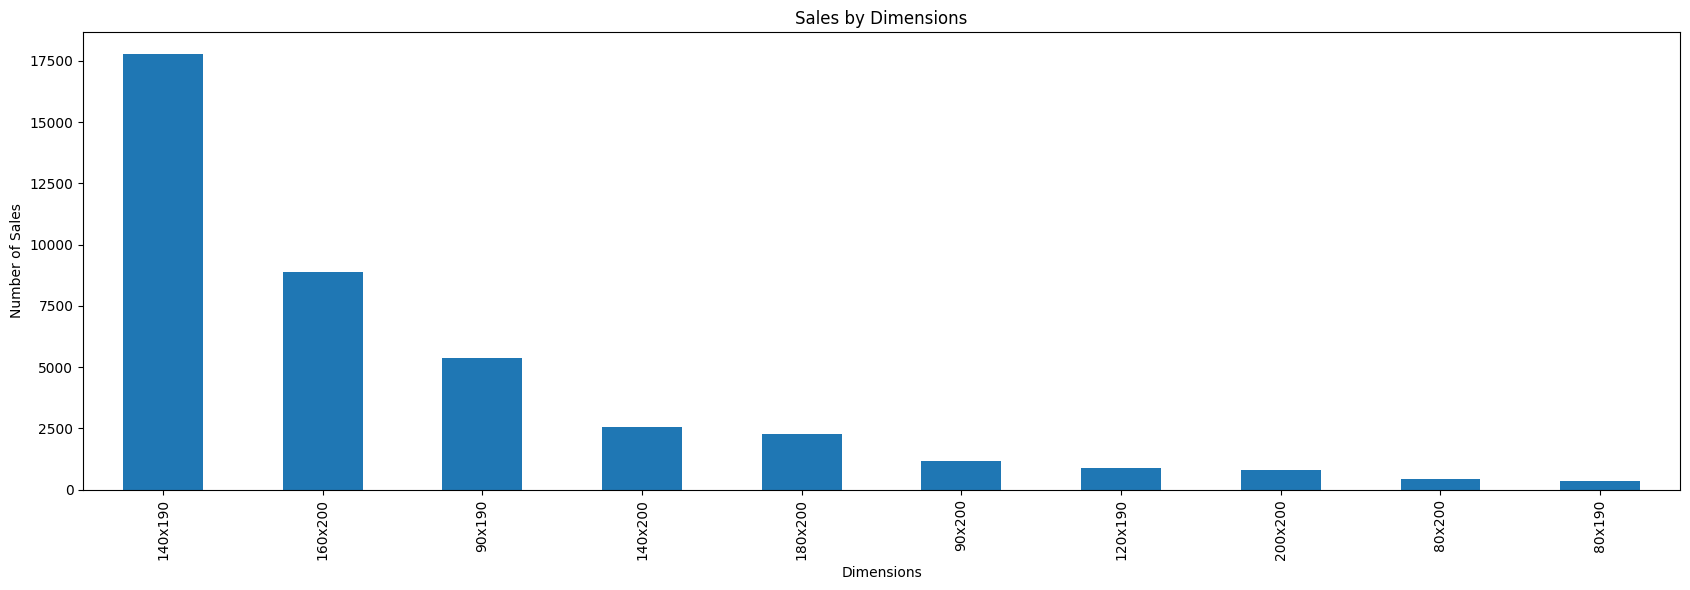

In [18]:
dim_f = mattress_data[mattress_data['Dimensions'] != 'N/F']
dim_c = dim_f['Dimensions'].value_counts().head(10)


 
plt.figure(figsize=(17, 6))
dim_c.plot(kind='bar')
plt.title('Sales by Dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Number of Sales')
plt.tight_layout()
plt.show()

1. Top 10 Sales by Dimensions.
2. The products with the most sales are 140x190. 
3. Most customers perfer queen size bed.

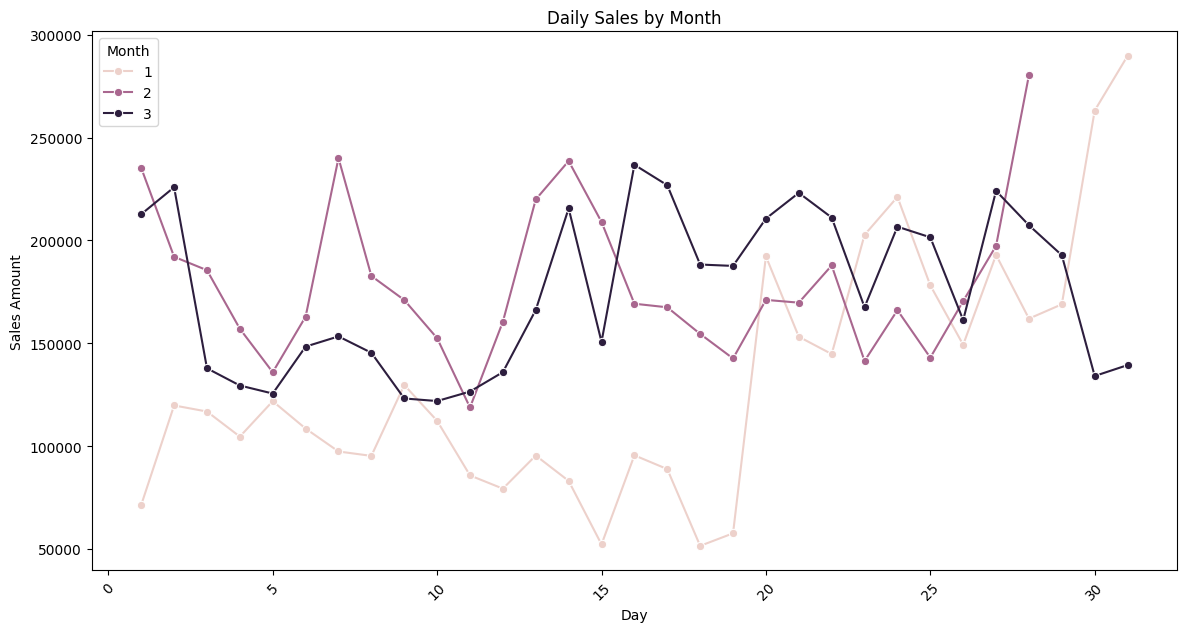

In [15]:
# Daily sales by each month 
daily_sales = mattress_data.groupby(['Month', 'Date de commande'])['Montant cmd'].sum().reset_index()
daily_sales['Date de commande'] = pd.to_datetime(daily_sales['Date de commande'])
daily_sales['Day'] = daily_sales['Date de commande'].dt.day
daily_sales['Month'] = daily_sales['Date de commande'].dt.month


# Plot daily sales by month
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sales, x='Day', y='Montant cmd', hue='Month', marker='o')
plt.title('Daily Sales by Month')
plt.xlabel('Day')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.show()


1. Each month exhibits its own daily sales fluctuations
2.  For example, in month 1, we see a downward trend starting from day 1, reaching a trough at day 5 and then slightly rising again at day 30 where as sales are highest for month 3, with a peak at 1st week and mid week.

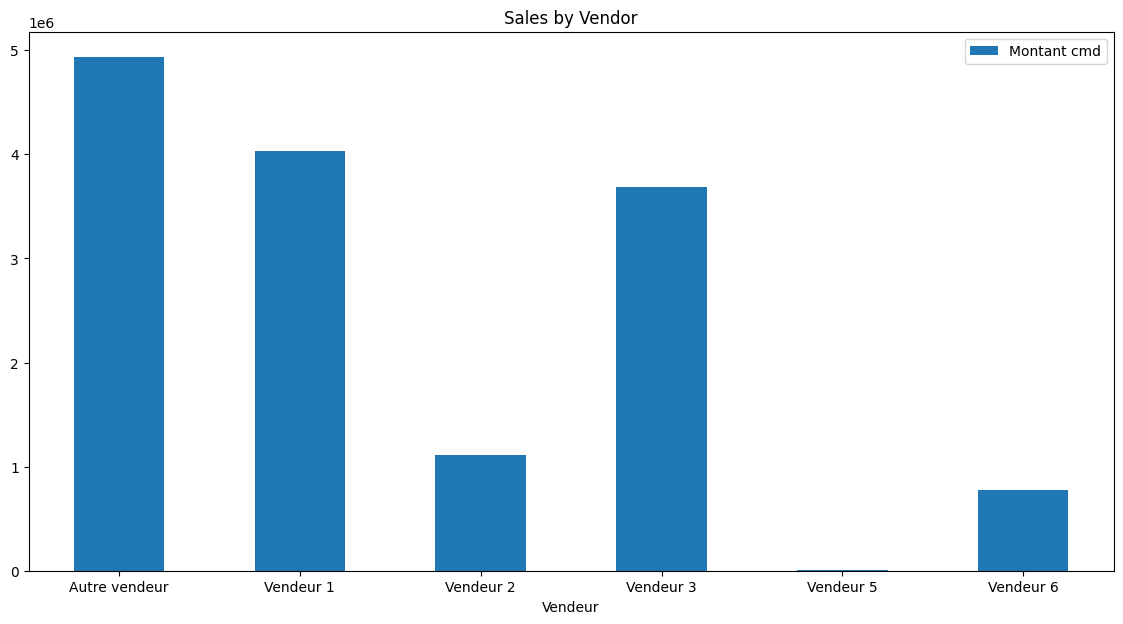

In [16]:
vendor_sales = mattress_data.groupby('Vendeur')['Montant cmd'].sum().reset_index()
vendor_sales.plot.bar(x='Vendeur', y='Montant cmd', rot=0,
                        title='Sales by Vendor', figsize=(14, 7))
plt.show()

The vendor with the highest sales is "Autre vendeur," followed by "Vendeur 1" and "Vendeur 3." "Vendeur 2," "Vendeur 6" and "Vendeur 5" had significantly less sales.

What factors can influence the volume and evolution sales on all mattresses?

1. Seasonality - Sales may vary by season, with peak sales during summer or holiday seasons when people tend to buy new mattresses.
2. Vendor performance - The sales performance of individual vendors, such as Vendeur 1, Vendeur 2, etc., can impact overall sales volume and evolution.
3. Marketing and advertising- Effective marketing and advertising campaigns can increase sales, while a lack of promotion can lead to stagnant or declining sales.
4. Competition- The presence of other mattress sellers in the market can influence sales, as customers may choose to buy from competitors instead.
5. Product offerings and quality- The types and quality of mattresses offered can impact sales, with customers seeking out high-quality products.
6. Customer preferences and trends- Shifts in customer preferences, such as a growing demand for eco-friendly or smart mattresses, can impact sales.

In [19]:
mattress_data.to_csv('../../data/mattress_data.csv', index=False)